Data downloaded from Kaggle "Real estate price prediction": https://www.kaggle.com/quantbruce/real-estate-price-prediction

Data:
- Transaction date (purchase)
- House age
- Distance to the nearest MRT station (metric not defined)
- Amount of convenience stores
- Location (latitude and longitude)
- House price of unit area 





In [1]:
#!pip install hdbscan

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
from scipy.stats import shapiro     #normality test
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from scipy.spatial import distance
from sklearn.decomposition import PCA
from yellowbrick.regressor import ResidualsPlot
from mpl_toolkits.mplot3d import Axes3D   #plot 3D
from hdbscan import HDBSCAN



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


#Pre-processing

- Reading dataset 

In [3]:
# reading dataset 
data = pd.read_csv("/content/drive/MyDrive/Codes/Real estate.csv")    #data = pd.read_csv("./Real estate.csv")

print(data.info(),
      '\n___________duplicated()___________\n', data.duplicated().any(), 
      '\n___________isnull()___________\n', data.isnull().sum()
      )
data.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 8 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   No                                      414 non-null    int64  
 1   X1 transaction date                     414 non-null    float64
 2   X2 house age                            414 non-null    float64
 3   X3 distance to the nearest MRT station  414 non-null    float64
 4   X4 number of convenience stores         414 non-null    int64  
 5   X5 latitude                             414 non-null    float64
 6   X6 longitude                            414 non-null    float64
 7   Y house price of unit area              414 non-null    float64
dtypes: float64(6), int64(2)
memory usage: 26.0 KB
None 
___________duplicated()___________
 False 
___________isnull()___________
 No                                        0
X1 transaction date           

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3


Dropping non useful columns

In [4]:
#dropping columns
columns_to_drop = ['X1 transaction date', 'No']
data = data.drop(columns_to_drop, axis=1)
data.head(3)

,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,32.0,84.87882,10,24.98298,121.54024,37.9
1,19.5,306.59470,9,24.98034,121.53951,42.2
2,13.3,561.98450,5,24.98746,121.54391,47.3


#Exporatory Data Analysis

Data distribution (2D and 3D plots)

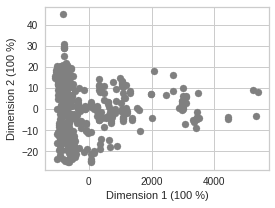

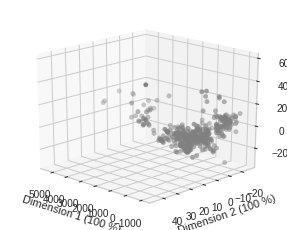

In [5]:
#data plot (2D and 3D)
def data_scatter(data_, pca, n_dim, ax):
  if(n_dim == 2):
    plt.scatter(data_[:,0], data_[:,1], color='grey')    #plot 2D
  else:
    ax.scatter(data_[:,0], data_[:,1], data_[:,2], color='grey')  #plot 3D
    ax.set_zlabel('Dimension 3 (%.f %%)' % (round(pca.explained_variance_ratio_.cumsum()[2], 2)*100)) #third principal component
  plt.xlabel('Dimension 1 (%.f %%)' % (round(pca.explained_variance_ratio_.cumsum()[0], 2)*100)) #first principal component
  plt.ylabel('Dimension 2 (%.f %%)' % (round(pca.explained_variance_ratio_.cumsum()[1], 2)*100)) #second principal component
  

#PCA: dimension reduction
pca = PCA()
data_ = pca.fit_transform(data)

#2D data plot
ax = plt.figure(figsize=(4, 3))
data_scatter(data_, pca, 2, ax)

#3D data plot
fig = plt.figure(figsize=(4, 3))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=20, azim=134)
data_scatter(data_, pca, 3, ax)

Features distribution (Histogram)

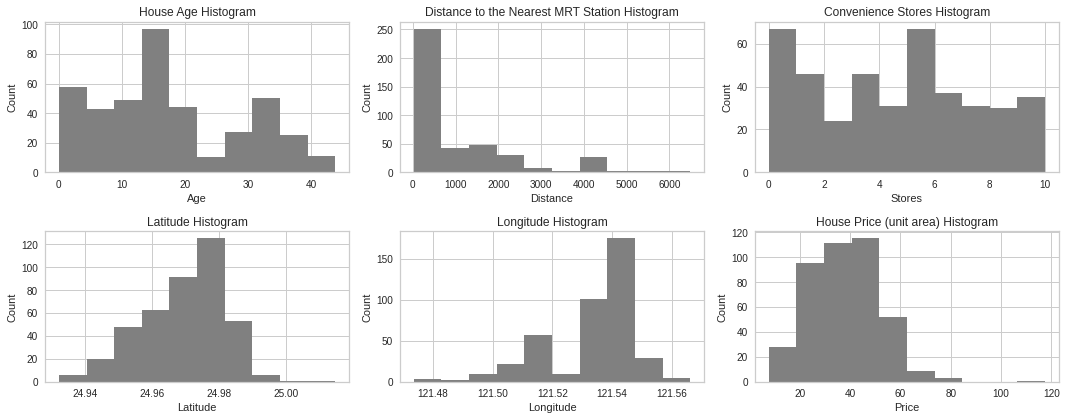

In [6]:
def hist_feature(data, x_ax, title):
  plt.hist(data, color='grey')
  plt.xlabel(x_ax)
  plt.ylabel('Count')
  plt.title(title)

plt.figure(figsize=(15,6))

plt.subplot(231)
hist_feature(data['X2 house age'], 'Age', 'House Age Histogram')

plt.subplot(232)
hist_feature(data['X3 distance to the nearest MRT station'], 'Distance', 'Distance to the Nearest MRT Station Histogram')

plt.subplot(233)
hist_feature(data['X4 number of convenience stores'], 'Stores', 'Convenience Stores Histogram')

plt.subplot(234)
hist_feature(data['X5 latitude'], 'Latitude', 'Latitude Histogram')

plt.subplot(235)
hist_feature(data['X6 longitude'], 'Longitude', 'Longitude Histogram')

plt.subplot(236)
hist_feature(data['Y house price of unit area'], 'Price', 'House Price (unit area) Histogram')

plt.tight_layout()

Box-plot

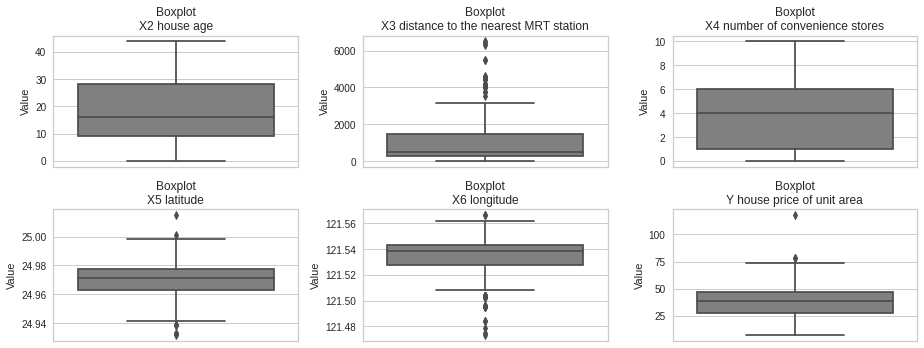

In [7]:
plt.figure(figsize=(13,5))

grid = [231, 232, 233, 234, 235, 236]
for feat, grd in zip(data, grid):
  plt.subplot(grd)
  sns.boxplot(y=data[feat], color='grey')
  plt.ylabel('Value')
  plt.title('Boxplot\n%s'%feat)
plt.tight_layout()

Dropping outliers
- Outlier defined by HDBSCAN clustering

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Text(0.5, 0, 'Dimension 2 (100 %)')

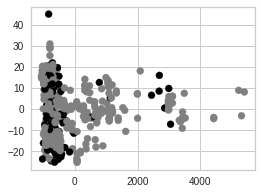

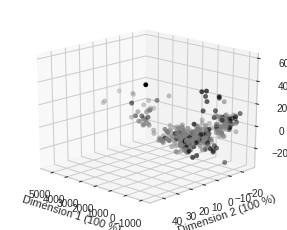

In [8]:
#HDBSCAN clustering
hdb = HDBSCAN(min_cluster_size=2).fit(data)
hdb_pred = hdb.labels_


#defining outlier
index_outlier = []
for i, out in zip(range(len(data)), hdb_pred):
  if out == -1:
    index_outlier.append(i)


#data visualization - 2D
fig = plt.figure(figsize=(4, 3))

#hdbscan plot color
#outliers color (as black)
#col_cl = cm.Set2(hdb_pred.astype(float) / np.max(hdb_pred))  
col_cl = ['grey'] * len(hdb_pred)
for k, i in zip(hdb_pred, range(len(hdb_pred))):            
  if k == -1:                            #outliers in "-1" group defined as black
    col_cl[i] = np.array([0, 0, 0, 1])   

plt.scatter(data_[:,0], data_[:,1], color=col_cl)    #plot 2D


#3D data plot
fig = plt.figure(figsize=(4, 3))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=20, azim=134)
ax.scatter(data_[:,0], data_[:,1], data_[:,2], color=col_cl)  #plot 3D
ax.set_zlabel('Dimension 3 (%.f %%)' % (round(pca.explained_variance_ratio_.cumsum()[2], 2)*100)) #third principal component
plt.xlabel('Dimension 1 (%.f %%)' % (round(pca.explained_variance_ratio_.cumsum()[0], 2)*100)) #first principal component
plt.ylabel('Dimension 2 (%.f %%)' % (round(pca.explained_variance_ratio_.cumsum()[1], 2)*100)) #second principal component


Data describe: without outlier defined by hdbscan


,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
count,337.000000,337.000000,337.000000,337.000000,337.000000,337.000000
mean,17.052819,1164.679430,3.946588,24.968309,121.532481,36.928190
std,10.893199,1304.871242,2.886256,0.012306,0.016118,12.875854
min,0.000000,23.382840,0.000000,24.938850,121.473530,11.200000
25%,8.900000,289.324800,1.000000,24.962990,121.518120,26.600000
50%,15.700000,533.476200,4.000000,24.969450,121.538420,38.100000
75%,26.600000,1712.632000,6.000000,24.977440,121.543200,45.700000
max,41.300000,6488.021000,10.000000,25.001150,121.566270,73.600000


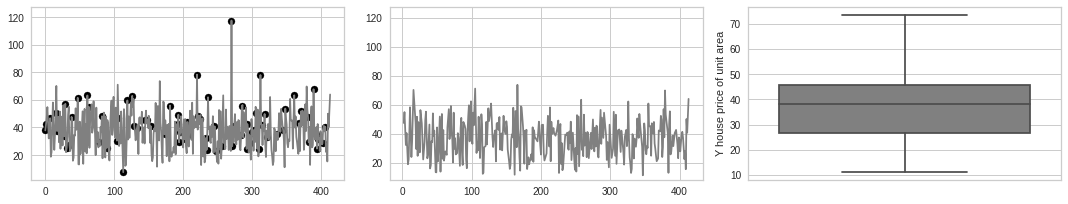

In [9]:
#visualizing new data (without outliers)
plt.figure(figsize=(15, 3))

#plot old data
plt.subplot(131)
plt.plot(data['Y house price of unit area'], color='grey')
plt.ylim(top=np.max(data['Y house price of unit area'])+10)
plt.scatter(index_outlier, data.loc[index_outlier]['Y house price of unit area'], color='black')

#defining new data
new_data = data.drop(index_outlier)

plt.subplot(132)
plt.plot(new_data['Y house price of unit area'], color='grey')
plt.ylim(top=np.max(data['Y house price of unit area'])+10)
plt.subplot(133)
sns.boxplot(y=new_data['Y house price of unit area'], color='grey')

plt.tight_layout()


print('\nData describe: without outlier defined by hdbscan')
new_data.describe()

Normality test

In [10]:
#normality Shapiro-Wilk test
stat, p_value = shapiro(new_data)    #Shapiro-Wilk test
alpha = 0.05

if p_value > alpha:
  print('Data normality: Gaussian')  #fail in reject H0 (null hypothesis H0: follow normal distribution)
else:
  print('Data normality: Non Gaussian') #reject H0 (alternative hypothesis H1: does not follow normal distribution)

Data normality: Non Gaussian


Correlation matrix
- Spearman (non-parametric method) due the normality test 

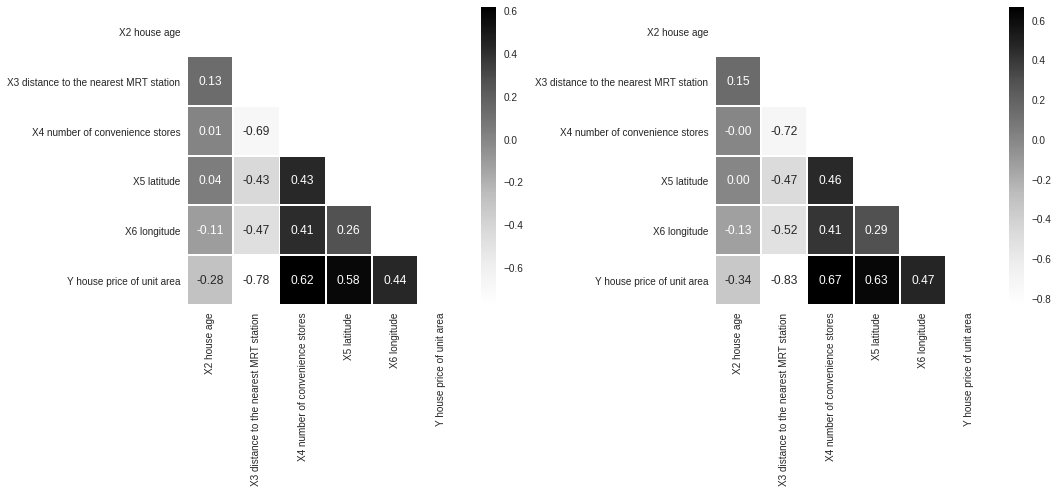

In [11]:
#correlation matrix
plt.subplots(figsize=(15, 7))

plt.subplot(121)
mask = np.triu(np.ones_like(data.corr())) 
sns.heatmap(data.corr(method='spearman'), annot=True, linewidths=.9, fmt= '.2f', cmap='Greys', mask=mask) #the non parametric method spearman rank is used

plt.subplot(122)
mask = np.triu(np.ones_like(new_data.corr())) 
sns.heatmap(new_data.corr(method='spearman'), annot=True, linewidths=.9, fmt= '.2f', cmap='Greys', mask=mask) #the non parametric method spearman rank is used

plt.tight_layout()

In [12]:
data = new_data.reset_index()

Feature comparison
- dependent and independent features

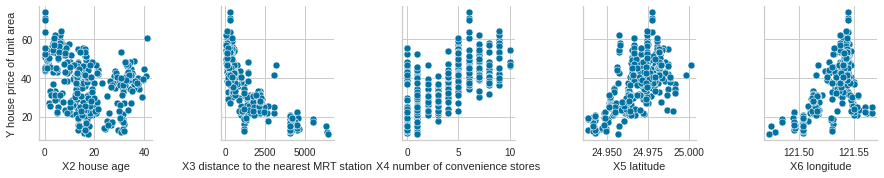

In [13]:
sns.pairplot(data, y_vars='Y house price of unit area',
             x_vars=['X2 house age', 'X3 distance to the nearest MRT station', 'X4 number of convenience stores', 'X5 latitude', 'X6 longitude']);

#Linear Regression

Prediction
- Train-test split
- Cross-validation

R2: coeficiente de determinação
- proximidade dos dados para a linha de regressão - measure variability proportion in y that can be explained from x
- 0: modelo não explica a variabilidade dos dados de resposta ao redor de sua média
- 1: modelo explica a variabilidade dos dados de resposta ao redor de sua média


MSE: média dos erros ao quadrado
- média do resíduo (erro) de cada um dos pontos ao quadrado


fonte: https://medium.com/@lauradamaceno/regress%C3%A3o-linear-6a7f247c3e29

In [14]:
#dropping columns
X = data.loc[:,'X2 house age' : 'X6 longitude']
y = data.loc[:,'Y house price of unit area']

#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

reg = LinearRegression().fit(X_train, y_train)    #fit train set

price_predict = reg.predict(X_test)

print('Coefficient of determination R2 (train): %.2f' % reg.score(X_train, y_train))
print('Coefficient of determination R2 (test): %.2f' % r2_score(y_test, price_predict))
print('Mean Square Error (train-test split): %.2f' % mean_squared_error(y_test, price_predict))    #mean squared error regression loss

#Cross-validation
price_predict_cv = cross_val_predict(reg, X, y, cv=10)

print('\nCoefficient of determination R2 (cross-validation): %.2f' % r2_score(y, price_predict_cv))
print('Mean Square Error (cross-validation): %.2f\n' % mean_squared_error(y, price_predict_cv))    #mean squared error regression loss

index_reg = ['Intercept', 'X2 house age', 'X3 distance to the nearest MRT station', 'X4 number of convenience stores', 'X4 number of convenience stores', 'X6 longitude']
pd.DataFrame(data=np.append(reg.intercept_, reg.coef_), index=index_reg, columns=['values']).transpose()

Coefficient of determination R2 (train): 0.74
Coefficient of determination R2 (test): 0.74
Mean Square Error (train-test split): 35.92

Coefficient of determination R2 (cross-validation): 0.73
Mean Square Error (cross-validation): 44.37



,Intercept,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X4 number of convenience stores,X6 longitude
values,-6945.654033,-0.396326,-0.003931,1.343136,273.142628,1.385861


Predictions plot

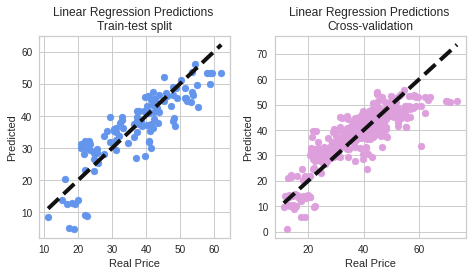

In [15]:
#Predictions plot
plt.figure(figsize=(10,4))

def plot_regression(real, predicted, color, title):
  plt.scatter(real, predicted, color=color)
  plt.plot([real.min(), real.max()], [real.min(), real.max()], 'k--', lw=4)
  plt.xlabel('Real Price')
  plt.ylabel('Predicted')
  plt.title(title)


#Real price vs train-test predictions plot
plt.subplot(131)
plot_regression(y_test, price_predict, 'cornflowerblue', 'Linear Regression Predictions \nTrain-test split')

#Real price vs cross-validation (all dataset) predictions plot
plt.subplot(132)
plot_regression(y, price_predict_cv, 'plum', 'Linear Regression Predictions \nCross-validation')


plt.tight_layout()
plt.show()

Normality (residuals)

In [16]:
residuals = y_test - price_predict


#normality Shapiro-Wilk test
stat, p_value = shapiro(residuals)    #Shapiro-Wilk test
alpha = 0.05

if p_value > alpha:
  print('Data normality: Gaussian')  #fail in reject H0 (null hypothesis H0: follow normal distribution)
else:
  print('Data normality: Non Gaussian') #reject H0 (alternative hypothesis H1: does not follow normal distribution)

Data normality: Gaussian


Homoscedasticity: residuals variance is equal

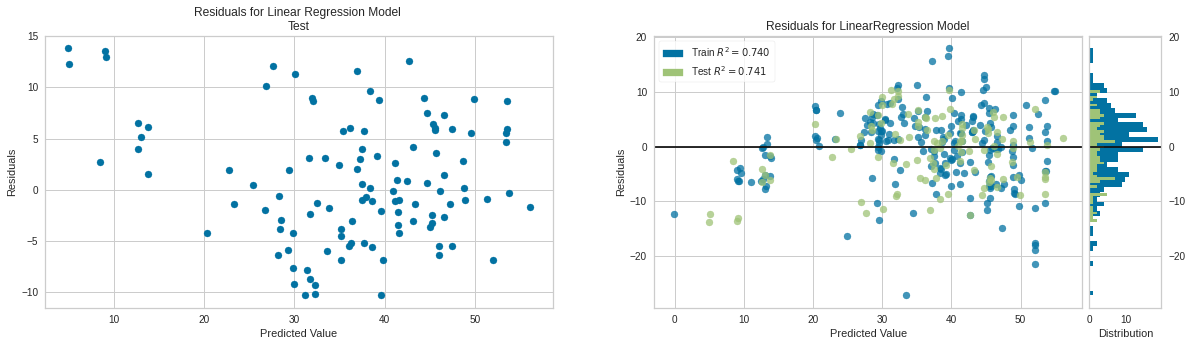

<Figure size 576x396 with 0 Axes>

In [17]:
plt.figure(figsize=(20,5))

plt.subplot(121)
plt.scatter(price_predict, residuals)
plt.title('Residuals for Linear Regression Model \nTest')
plt.xlabel('Predicted Value')
plt.ylabel('Residuals')


plt.subplot(122)
visualizer = ResidualsPlot(LinearRegression())
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof() 

plt.tight_layout()

Autocorrelation (residuals): OLS for Durbing-Watson test
- between 0 and 4
  - closer to 0: positive correlation
  - closer to 4: negative correlation
- test is approximately equal to 2*(1-r)
  - r equals zero indicates no correlation


In [18]:
import statsmodels.api as sm

est = sm.OLS(y, X)
est2 = est.fit()
print(est2.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


                                     OLS Regression Results                                    
Dep. Variable:     Y house price of unit area   R-squared (uncentered):                   0.972
Model:                                    OLS   Adj. R-squared (uncentered):              0.972
Method:                         Least Squares   F-statistic:                              2301.
Date:                        Mon, 01 Mar 2021   Prob (F-statistic):                   3.61e-255
Time:                                06:37:08   Log-Likelihood:                         -1111.5
No. Observations:                         337   AIC:                                      2233.
Df Residuals:                             332   BIC:                                      2252.
Df Model:                                   5                                                  
Covariance Type:                    nonrobust                                                  
                                        

In [19]:
Dubin_Watson = 1.972

if(round(1 - Dubin_Watson/2)) == 0:
  print('Without auto-correlation')
else:
  print('With auto-correlation')

Without auto-correlation


Prices plot
- Real and cross-validation
- Real and train-test split

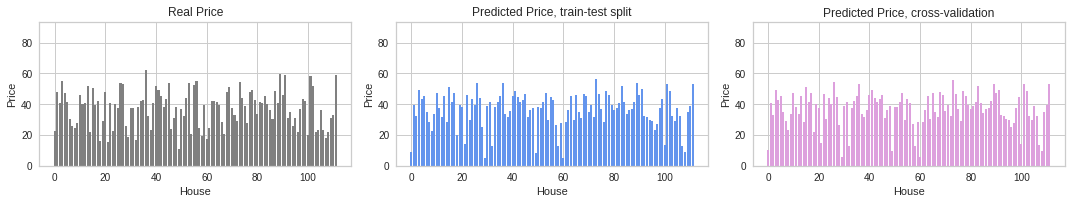

In [20]:
#Prices plot
max_pred = np.maximum(price_predict.max(), price_predict_cv.max())   #max price between predicteds price
max_price = np.maximum(y_train.max(), max_pred)   #max price between real and predicteds price
def real_plot(x_ax, y_ax, title, color):
  #plt.tight_layout()
  plt.bar(x_ax, y_ax, color=color)
  plt.ylim(top=max_price+20)
  plt.title(title)
  plt.ylabel('Price')
  plt.xlabel('House')

#Prices comparison plot (real and predicteds)
plt.figure(figsize=(20,3))

#Real price plot
plt.subplot(141)
real_plot(np.arange(len(y_test)), y_test, 'Real Price', 'grey')

#Predicted price plot
plt.subplot(142)
real_plot(np.arange(len(price_predict)), price_predict, 'Predicted Price, train-test split', 'cornflowerblue')

#Predicted price plot (all dataset)
plt.subplot(143)
real_plot(np.arange(len(y_test)), price_predict_cv[y_test.index], 'Predicted Price, cross-validation', 'plum')


plt.tight_layout()
plt.show()

Predictions comparison
- Plot
  - Real vs cross-validation
  - Real vs cross-validation vs train-test split (same split)
- Distance
  - Prediction distance in general (real vs cross-validation and real vs train-test split) 
  - Prediction distance between real, cross-validation and train-test split (same split / houses in common) 

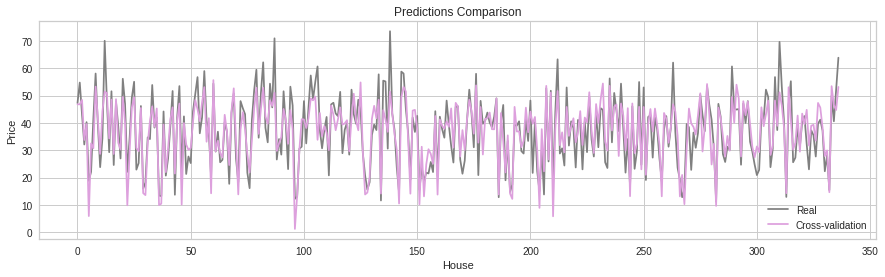

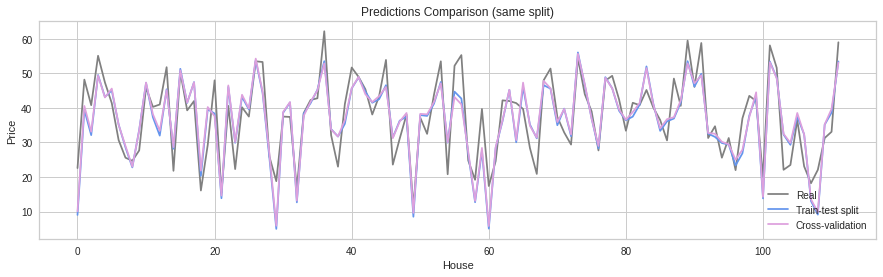


Euclidean distance between prices (in general)
- Real vs train-test: 63.428
- Real vs cross-validation: 122.280

Euclidean distance between prices (same split)
- Real vs train-test: 63.428
- Real vs cross-validation (all dataset): 63.321


In [21]:
plt.figure(figsize=(15,4))

plt.plot(np.array(y), color='grey', label='Real')
plt.plot(price_predict_cv, color='plum', label='Cross-validation')
plt.xlabel('House')
plt.ylabel('Price')
plt.title('Predictions Comparison')
plt.legend(loc=4)
plt.show()


plt.figure(figsize=(15,4))

plt.plot(np.array(y_test), color='grey', label='Real')
plt.plot(price_predict, color='cornflowerblue', label='Train-test split')
plt.plot(price_predict_cv[y_test.index], color='plum', label='Cross-validation')
plt.xlabel('House')
plt.ylabel('Price')
plt.title('Predictions Comparison (same split)')
plt.legend(loc=4)
plt.show()


#Predictions comparison plot
#Predictions distance (in general)
print('\nEuclidean distance between prices (in general)')
print('- Real vs train-test: %.3f' % distance.euclidean(y_test, price_predict))
print('- Real vs cross-validation: %.3f' % distance.euclidean(y, price_predict_cv))


#Predictions comparison plot
#Predictions distance (cross validation and train-test split set are the same)
print('\nEuclidean distance between prices (same split)')
print('- Real vs train-test: %.3f' % distance.euclidean(y_test, price_predict))
print('- Real vs cross-validation (all dataset): %.3f' % distance.euclidean(y_test, price_predict_cv[y_test.index]))